# 패키지 임포드

In [3]:
import os
import json
import shutil
import chardet
import pandas as pd
from PIL import Image

# 데이터 기초 처리

데이터를 추가로 다운 받았을떄 사용

## 이미지 파일 폴더 하나에 모으기

In [ ]:
def collect_png_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.endswith(".png") and "index" not in file:
                source_path = os.path.join(root, file)
                destination_path = os.path.join(destination_dir, file)
                
                # 파일이 존재하면 덮어쓰기
                shutil.copy2(source_path, destination_path)
                print(f"복사 완료: {destination_path}")

source_directory = r""  # 원본 폴더 경로 설정
destination_directory = "./train_images"  # 파일을 저장할 폴더 경로 설정

collect_png_files(source_directory, destination_directory)

## 손상된 이미지 삭제

In [ ]:
def find_and_remove_corrupt_images(root_folder):
    corrupt_files = []

    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                file_path = os.path.join(dirpath, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # 파일이 정상적으로 열리는지 확인
                except (IOError, SyntaxError):
                    print(f"손상된 파일 발견 및 삭제: {file_path}")
                    corrupt_files.append(file_path)
                    os.remove(file_path)  # 파일 삭제

    return corrupt_files

# 사용 예제
image_root_directory = "train_images"  # 이미지 파일이 있는 최상위 폴더 경로 설정
corrupt_images = find_and_remove_corrupt_images(image_root_directory)

if corrupt_images:
    print("\n삭제된 손상된 이미지 파일 목록:")
    for corrupt_file in corrupt_images:
        print(corrupt_file)
else:
    print("\n손상된 이미지가 없습니다.")

## json 파일 수정

In [ ]:
def detect_encoding(file_path):
    """파일의 인코딩을 감지하는 함수"""
    with open(file_path, "rb") as f:
        raw_data = f.read(100000)  # 일부 데이터만 읽어 인코딩 감지
        result = chardet.detect(raw_data)
        return result["encoding"] if result["encoding"] else None

def fix_json_files(root_folder, start_id=1490):
    file_id_map = {}  # file_name을 기준으로 ID 매핑 저장
    current_id = start_id

    for dirpath, _, filenames in os.walk(root_folder):  # 모든 하위 폴더 탐색
        for filename in filenames:
            if filename.endswith(".json"):
                file_path = os.path.join(dirpath, filename)

                # 인코딩 감지
                encoding = detect_encoding(file_path)

                # UTF-8이 아니면 파일 삭제
                if encoding is None or encoding.lower() not in ["utf-8", "ascii"]:
                    print(f"UTF-8이 아님 -> 파일 삭제: {file_path} (감지된 인코딩: {encoding})")
                    os.remove(file_path)
                    continue

                # JSON 파일 로드
                try:
                    with open(file_path, "r", encoding="utf-8") as file:
                        data = json.load(file)
                except (UnicodeDecodeError, json.JSONDecodeError):
                    print(f"JSON 오류 발생 -> 파일 삭제: {file_path}")
                    os.remove(file_path)
                    continue  # 오류 발생 시 해당 파일 삭제 후 다음으로 진행

                if "images" in data and "annotations" in data and "categories" in data:
                    images_info = {}  # image id 매핑용 임시 딕셔너리
                    category_map = {}  # 카테고리 정보 저장
                    new_categories = []

                    # images의 id를 file_name 기준으로 통일
                    for image in data["images"]:
                        file_name = image["file_name"]
                        if file_name in file_id_map:
                            new_id = file_id_map[file_name]
                        else:
                            new_id = current_id
                            file_id_map[file_name] = current_id
                            current_id += 1

                        image["id"] = new_id  # 새로운 ID 할당
                        images_info[image["id"]] = image  # 매핑 저장

                    # annotations의 image_id 업데이트
                    for annotation in data["annotations"]:
                        old_image_id = annotation["image_id"]
                        if old_image_id in images_info:
                            annotation["image_id"] = images_info[old_image_id]["id"]
                            annotation["category_id"] = int(images_info[old_image_id]["dl_idx"])  # category_id 수정

                    # categories 정보 업데이트
                    for image in data["images"]:
                        dl_idx = int(image["dl_idx"])
                        dl_name = image["dl_name"]

                        if dl_idx not in category_map:
                            category_map[dl_idx] = dl_name
                            new_categories.append({
                                "supercategory": "pill",
                                "id": dl_idx,
                                "name": dl_name
                            })

                    data["categories"] = new_categories  # 업데이트된 categories 반영

                    # 수정된 JSON 파일 저장
                    with open(file_path, "w", encoding="utf-8") as file:
                        json.dump(data, file, indent=4, ensure_ascii=False)

                    print(f"수정 완료: {file_path}")

json_root_directory = "train_annotations"  # 최상위 폴더 경로 설정
fix_json_files(json_root_directory)

## 매칭되는 이미지가 없는 json 삭제

In [ ]:
def remove_invalid_json(annotation_folder, image_folder):
    deleted_jsons = []

    for dirpath, _, filenames in os.walk(annotation_folder):  # 주석 파일 탐색
        for filename in filenames:
            if filename.endswith(".json"):
                file_path = os.path.join(dirpath, filename)

                # JSON 파일 로드
                with open(file_path, "r", encoding="utf-8") as file:
                    try:
                        data = json.load(file)
                    except json.JSONDecodeError:
                        print(f"잘못된 JSON 파일 발견 및 삭제: {file_path}")
                        os.remove(file_path)
                        deleted_jsons.append(file_path)
                        continue

                if "images" not in data:
                    print(f"'images' 키 없음 -> JSON 삭제: {file_path}")
                    os.remove(file_path)
                    deleted_jsons.append(file_path)
                    continue

                # 이미지 파일 존재 여부 확인
                all_images_exist = True
                for image in data["images"]:
                    image_path = os.path.join(image_folder, image["file_name"])
                    if not os.path.exists(image_path):  # 이미지 파일이 없으면 JSON 삭제
                        print(f"해당 이미지 없음 -> JSON 삭제: {file_path}")
                        os.remove(file_path)
                        deleted_jsons.append(file_path)
                        all_images_exist = False
                        break  # 하나라도 없으면 삭제 후 반복 종료

                if all_images_exist:
                    print(f"유효한 JSON 파일 유지: {file_path}")

    return deleted_jsons

# 사용 예제
annotation_root = "train_annotations"  # 주석 파일(JSON) 폴더 경로
image_root = "train_images"  # 이미지가 저장된 폴더 경로

deleted_files = remove_invalid_json(annotation_root, image_root)

if deleted_files:
    print("\n삭제된 JSON 파일 목록:")
    for deleted in deleted_files:
        print(deleted)
else:
    print("\n모든 JSON 파일이 유효합니다.")

## Annotations to CSV

In [4]:
# 데이터가 저장된 폴더 경로
root_dir = "../data/train_annotations"
image_root_dir = "../data/train_images"

# JSON 데이터를 저장할 리스트
image_data = []
annotation_data = []

# 각 폴더를 순회하며 데이터 수집
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    if os.path.isdir(folder_path):
        for drug_folder in os.listdir(folder_path):
            drug_folder_path = os.path.join(folder_path, drug_folder)
            
            if os.path.isdir(drug_folder_path):
                for json_file in os.listdir(drug_folder_path):
                    if json_file.endswith(".json"):
                        json_path = os.path.join(drug_folder_path, json_file)

                        with open(json_path, "r", encoding="utf-8") as f:
                            data = json.load(f)

                        # 이미지 정보 저장
                        for img in data["images"]:
                            img_path = os.path.join(image_root_dir, img["file_name"])

                            # dl_idx를 숫자로 변환
                            try:
                                dl_idx_numeric = int(img["dl_idx"])
                            except (ValueError, TypeError):
                                dl_idx_numeric = -1

                            image_data.append({
                                "file_name": img["file_name"],
                                "image_id": img["id"],
                                "width": img["width"],
                                "height": img["height"],
                                "img_path": img_path if os.path.exists(img_path) else None,
                                "drug_name": img.get("dl_name", "Unknown"),
                                "drug_material": img.get("dl_material", "Unknown"),
                                "company": img.get("dl_company", "Unknown"),
                                "dl_idx": dl_idx_numeric
                            })

                        # 주석 정보 저장
                        for ann in data["annotations"]:
                            annotation_data.append({
                                "image_id": ann["image_id"],
                                "bbox": tuple(ann["bbox"]),
                                "area": ann["area"],
                                "category_id": ann["category_id"]
                            })

# 데이터프레임 변환
df_images = pd.DataFrame(image_data)
df_annotations = pd.DataFrame(annotation_data)

# 이미지와 주석을 병합
df_merged = df_images.merge(df_annotations, on=["image_id"], how="inner")

# category_id와 dl_idx가 같은 경우만 유지
df_filtered = df_merged[df_merged["category_id"] == df_merged["dl_idx"]].copy()

# 파일 이름에서 알약 개수 추출
def extract_pill_count(file_name):
    try:
        base_name = file_name.split("_")[0]  
        number_parts = base_name[1:].split("-")  
        return len(number_parts[1:])
    except:
        return -1  

df_filtered.loc[:, "pill_count"] = df_filtered["file_name"].apply(extract_pill_count)

# image_id별 category_id 개수 계산
df_category_count = df_filtered.groupby("image_id")["category_id"].count().reset_index()
df_category_count.rename(columns={"category_id": "category_count"}, inplace=True)

# 데이터 병합
df_filtered = df_filtered.merge(df_category_count, on="image_id", how="left")
df_filtered = df_filtered[df_filtered["category_count"] == df_filtered["pill_count"]]

# 중복 category_id 제거 함수
def remove_duplicates(category_ids, bboxes, areas):
    """ category_id 기준으로 중복을 제거하면서 bbox, area도 정리 """
    unique_data = {}
    for idx, cid in enumerate(category_ids):
        if cid not in unique_data:
            unique_data[cid] = (bboxes[idx], areas[idx])
    
    unique_category_ids = list(unique_data.keys())
    unique_bboxes = [unique_data[cid][0] for cid in unique_category_ids]
    unique_areas = [unique_data[cid][1] for cid in unique_category_ids]

    return unique_category_ids, unique_bboxes, unique_areas

# 데이터 그룹화 및 중복 제거
df_grouped = df_filtered.groupby("image_id").agg({
    "file_name": "first",
    "img_path": "first",
    "width": "first",
    "height": "first",
    "drug_name": lambda x: list(set(x)),
    "drug_material": lambda x: list(set(x)),
    "company": lambda x: list(set(x)),
    "dl_idx": lambda x: list(set(x)),
    "category_id": lambda x: list(x),  # 중복 제거 전 리스트 유지
    "bbox": lambda x: list(x),  # 중복 제거 전 리스트 유지
    "area": lambda x: list(x),  # 중복 제거 전 리스트 유지
    "pill_count": "first",  
    "category_count": "first"  
}).reset_index()

# 중복 제거 적용
df_grouped[["category_id", "bbox", "area"]] = df_grouped.apply(
    lambda row: remove_duplicates(row["category_id"], row["bbox"], row["area"]),
    axis=1,
    result_type="expand"
)

# CSV 저장
df_grouped.to_csv("image_annotations.csv", index=False, encoding="utf-8-sig")

# 결과 출력
print(df_grouped.shape)
df_grouped.head()

(2079, 14)


,image_id,file_name,img_path,width,height,drug_name,drug_material,company,dl_idx,category_id,bbox,area,pill_count,category_count
0,2,K-001900-016551-024850-027926_0_2_0_2_70_000_2...,../data/train_images\K-001900-016551-024850-02...,976,1280,"[놀텍정 10mg, 보령부스파정 5mg, 울트라셋이알서방정, 동아가바펜틴정 800mg]","[아세트아미노펜|트라마돌염산염, 일라프라졸, 가바펜틴, 부스피론염산염]","[일양약품(주), 보령제약(주), (주)한국얀센, 동아에스티(주)]","[24849, 1899, 27925, 16550]","[1899, 16550, 24849, 27925]","[(631, 893, 210, 133), (29, 762, 412, 419), (6...","[27930.0, 172628.0, 49128.0, 117192.0]",4,4
1,6,K-001900-016551-024850-029345_0_2_0_2_75_000_2...,../data/train_images\K-001900-016551-024850-02...,976,1280,"[놀텍정 10mg, 보령부스파정 5mg, 비모보정 500/20mg, 동아가바펜틴정 ...","[나프록센|에스오메프라졸마그네슘삼수화물, 일라프라졸, 가바펜틴, 부스피론염산염]","[일양약품(주), 보령제약(주), 한국아스트라제네카(주), 동아에스티(주)]","[29344, 24849, 1899, 16550]","[1899, 16550, 24849, 29344]","[(163, 257, 126, 201), (541, 101, 276, 465), (...","[25326.0, 128340.0, 50736.0, 129558.0]",4,4
2,7,K-003483-020238-022347-027653_0_2_0_2_70_000_2...,../data/train_images\K-003483-020238-022347-02...,976,1280,"[세비카정 10/40mg, 자누비아정 50mg, 플라빅스정 75mg, 기넥신에프정(...","[클로피도그렐황산염, 시타글립틴인산염수화물, 은행엽건조엑스, 올메사르탄메독소밀|암로...","[한국다이이찌산쿄(주), (주)한독, 에스케이케미칼(주), 한국엠에스디(주)]","[3482, 27652, 20237, 22346]","[3482, 20237, 22346, 27652]","[(130, 289, 276, 172), (133, 870, 230, 226), (...","[47472.0, 51980.0, 44308.0, 43581.0]",4,4
3,11,K-001900-016548-021771-029451_0_2_0_2_90_000_2...,../data/train_images\K-001900-016548-021771-02...,976,1280,"[가바토파정 100mg, 라비에트정 20mg, 보령부스파정 5mg, 레일라정]","[라베프라졸나트륨, 당귀·모과·방풍·속단·오가피·우슬·위령선·육계·진교·천궁·천마·...","[보령제약(주), 동아에스티(주), (주)한국피엠지제약, 일동제약(주)]","[21770, 1899, 29450, 16547]","[1899, 16547, 21770, 29450]","[(168, 249, 184, 181), (643, 225, 244, 227), (...","[33304.0, 55388.0, 35696.0, 90688.0]",4,4
4,12,K-001900-016548-021771-029451_0_2_0_2_75_000_2...,../data/train_images\K-001900-016548-021771-02...,976,1280,"[가바토파정 100mg, 라비에트정 20mg, 보령부스파정 5mg, 레일라정]","[라베프라졸나트륨, 당귀·모과·방풍·속단·오가피·우슬·위령선·육계·진교·천궁·천마·...","[보령제약(주), 동아에스티(주), (주)한국피엠지제약, 일동제약(주)]","[21770, 1899, 29450, 16547]","[1899, 16547, 21770, 29450]","[(149, 242, 181, 180), (616, 216, 234, 226), (...","[32580.0, 52884.0, 36075.0, 93060.0]",4,4


## json이 완전하지 않은 이미지 삭제

In [5]:
import os

# 이미지가 저장된 폴더 경로
image_folder = "../data/train_images"

# 데이터프레임에 있는 이미지 파일명 목록 (집합으로 저장하여 검색 속도 향상)
valid_filenames = set(df_grouped["file_name"])

# 폴더 내 모든 이미지 파일 확인
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)

    # 파일이 이미지이고, 데이터프레임에 존재하지 않는 경우 삭제
    if os.path.isfile(file_path) and filename not in valid_filenames:
        os.remove(file_path)
        print(f"삭제됨: {file_path}")

print("정리 완료: 데이터프레임에 없는 이미지가 삭제되었습니다.")

삭제됨: ../data/train_images\K-000250-000573-002483-006192_0_2_0_2_70_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-006192_0_2_0_2_75_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-006192_0_2_0_2_90_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-012778_0_2_0_2_70_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-012778_0_2_0_2_75_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-012778_0_2_0_2_90_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-019552_0_2_0_2_70_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-019552_0_2_0_2_75_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-019552_0_2_0_2_90_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-022627_0_2_0_2_70_000_200.png
삭제됨: ../data/train_images\K-000250-000573-002483-022627_0_2_0_2_75_000_200.png
삭제됨: ../data/train_images\K-001900-003544-004543-016548_0_2_0_2_75_000_200.png
삭제됨: ../data/train_images\K-001900-003544-004543-016

# 데이터 EDA

## Bounding Box 시각화

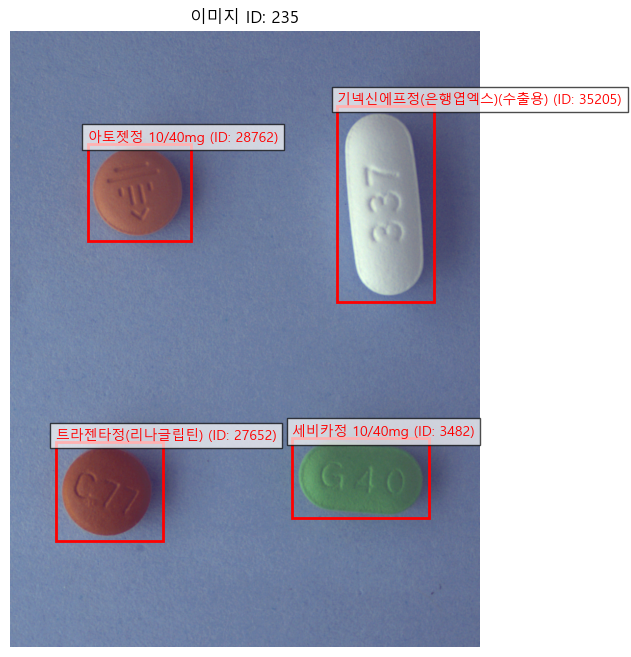

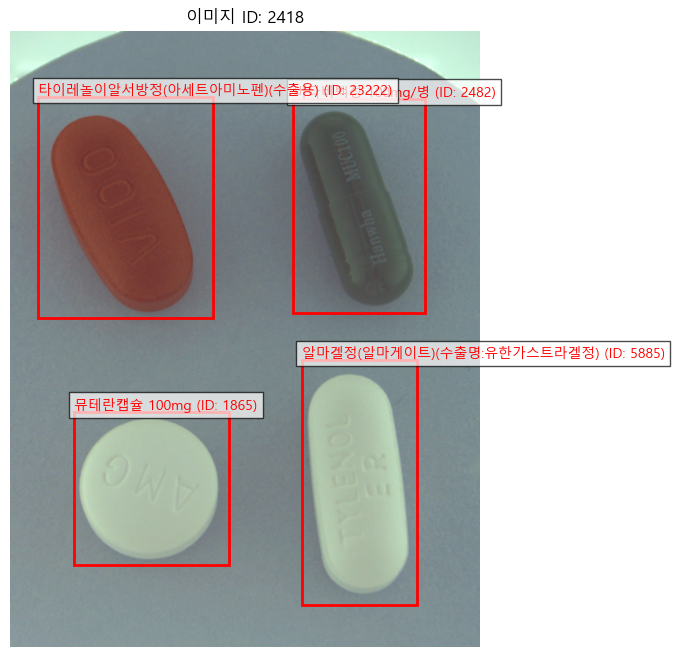

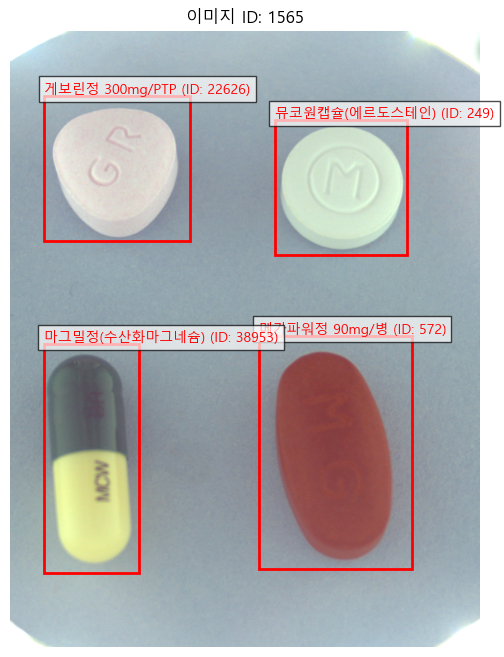

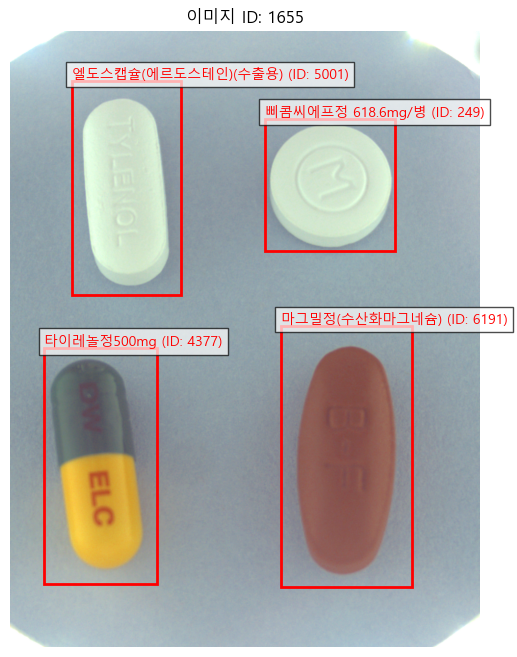

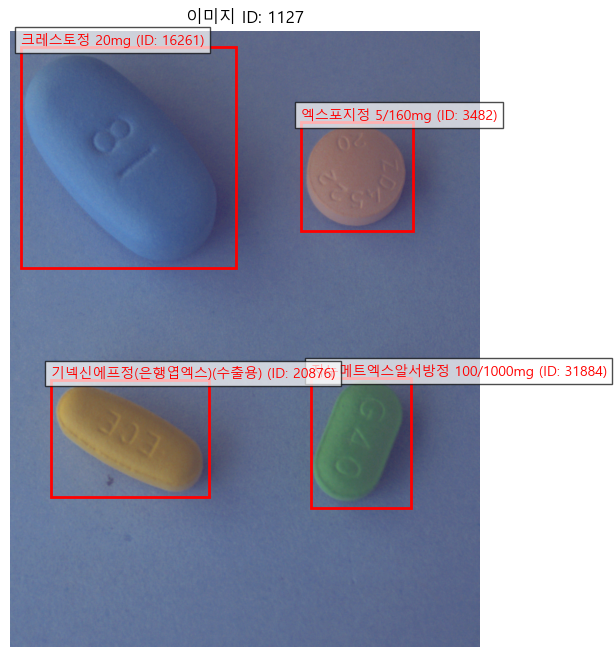

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cv2

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 윈도우 (맑은 고딕)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def visualize_annotations(df, image_root_dir, num_samples=5):
    """
    이미지와 bounding box를 시각화

    Parameters:
    - df: 데이터프레임 (image_id, bbox, drug_name 포함)
    - image_root_dir: 이미지가 저장된 폴더 경로
    - num_samples: 시각화할 이미지 개수
    """
    sample_images = df.sample(n=min(num_samples, len(df)))  
    
    for _, row in sample_images.iterrows():
        image_path = row["img_path"]
        if not os.path.exists(image_path):
            print(f"이미지를 찾을 수 없습니다: {image_path}")
            continue
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image)

        # bounding box 그리기
        for bbox, drug_name, category_id in zip(row["bbox"], row["drug_name"], row["dl_idx"]):
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            label_text = f"{drug_name} (ID: {category_id})"
            ax.text(x, y - 5, label_text, color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

        ax.set_title(f"이미지 ID: {row['image_id']}")
        plt.axis("off")
        plt.show()

# 시각화 실행
visualize_annotations(df_grouped, image_root_dir, num_samples=5)